# Lab 5 Pt. 1 - Logistic Regression

In this lab, we'll do the following:
1. Introduce robust errors
2. Run a logistic regression & analyze odds ratios
3. Plot predicted probabilities

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor ### VIF package
from statsmodels.discrete.discrete_model import Logit

/srv/app/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load & Clean the Data

In [3]:
raw = pd.read_csv ('data.csv')

#Create df copy with variables of interest
var_list = ['price_000','pop_dens','ses','house','area_m2','num_bath','pcn_green','homicides', 'year']
data = raw[var_list].copy()
data.head()

,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,homicides,year
0,60000,830.78,4,0,70,2,1.74,39.92,2001
1,140000,826.75,4,1,257,4,0.54,46.00,2002
2,38000,914.15,4,0,115,4,1.55,45.87,2002
3,110000,911.25,4,1,270,4,1.58,45.88,2002
4,120000,757.37,4,1,268,2,0.40,46.00,2002


#### Recoding Variables

Let's redefine the socieconomic status - this is the same process we did in lab 3!

In [4]:
#Create SES Dummy Variable
data['high_ses'] = np.where(data['ses']>=5, 1, 0)

Now, let's create dummy variables for the year the property was sold. There are 6 unique years, and we can create a new dummy column for each year. This could be a long process, but python can make this easier for us!

In [5]:
data['year'].unique()

array([2001, 2002, 2004, 2003, 2005, 2006])

In [6]:
#One Hot-Encode Year Variable
dummies = pd.get_dummies(data['year'], prefix = 'yr') 
dummies.head()

,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [7]:
#Append the dummies to our larger dataframe
data = pd.concat([data, dummies], axis = 1)
data.head()

,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,homicides,year,high_ses,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006
0,60000,830.78,4,0,70,2,1.74,39.92,2001,0,1,0,0,0,0,0
1,140000,826.75,4,1,257,4,0.54,46.00,2002,0,0,1,0,0,0,0
2,38000,914.15,4,0,115,4,1.55,45.87,2002,0,0,1,0,0,0,0
3,110000,911.25,4,1,270,4,1.58,45.88,2002,0,0,1,0,0,0,0
4,120000,757.37,4,1,268,2,0.40,46.00,2002,0,0,1,0,0,0,0


### 1. Introduce Robust Errors Into a Multivariate Linear Regression Model

We'll be running a similiar multivariate regression model to the one we used for Lab 3

#### Without Robust Errors

In [8]:
#Define Independent Variables of Interest
ind_var = ['high_ses', 'house', 'area_m2', 'num_bath', 'pcn_green', 'homicides','yr_2002','yr_2003','yr_2004','yr_2005','yr_2006'] 
#Note that the year variable is categorical. We need to exclude one to prevent collinearity issues with out model
#We will exclude year 2001 - we choose to have the earlier year be our base year

x = data[ind_var].assign(Intercept = 1) #Independent Variables
y = data['price_000'] #Dependent Variable

model = sm.OLS(y, x).fit()
### Let's save the results as "model" - this will be useful for other functions below.

model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS               Adj. R-squared:      0.526     
Dependent Variable:   price_000         AIC:                 97643.6615
Date:                 2020-02-25 18:58  BIC:                 97719.1179
No. Observations:     3976              Log-Likelihood:      -48810.   
Df Model:             11                F-statistic:         402.2     
Df Residuals:         3964              Prob (F-statistic):  0.00      
R-squared:            0.527             Scale:               2.7023e+09
-----------------------------------------------------------------------
             Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
-----------------------------------------------------------------------
high_ses   72215.4064 3151.9478  22.9114 0.0000  66035.8154  78394.9973
house     -25760.7177 2439.5596 -10.5596 0.0000 -30543.6271 -20977.8084
area_m2      566.9380   14.3065  39.6279 0.0000    538.8891    594.9868
num_bath   10559.7664  957.8052  11.0250 0.0000   8681.9293  12437.6035
pcn_green    161.1475  115.4937   1.3953 0.1630    -65.2851    387.5801
homicides    -24.0329   16.0238  -1.4998 0.1337    -55.4485      7.3827
yr_2002     -265.7563 3186.9542  -0.0834 0.9335  -6513.9796   5982.4670
yr_2003     8079.4845 3055.2693   2.6444 0.0082   2089.4377  14069.5314
yr_2004     8448.0953 2749.0138   3.0731 0.0021   3058.4817  13837.7090
yr_2005    18176.6143 2862.9095   6.3490 0.0000  12563.7010  23789.5276
yr_2006    23245.8901 3213.0725   7.2348 0.0000  16946.4602  29545.3200
Intercept  -4589.4649 3273.0502  -1.4022 0.1609 -11006.4848   1827.5550
-----------------------------------------------------------------------
Omnibus:              3155.431       Durbin-Watson:          0.919     
Prob(Omnibus):        0.000          Jarque-Bera (JB):       130563.264
Skew:                 3.445          Prob(JB):               0.000     
Kurtosis:             30.215         Condition No.:          1182      
=======================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

#### With Robust Errors
Take a look at the output - what's changed? What's stayed the same?

In [9]:
model = sm.OLS(y, x).fit(cov_type='HC0') ##cov_type='HC0' introduces robust errors
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
======================================================================
Model:               OLS               Adj. R-squared:      0.526     
Dependent Variable:  price_000         AIC:                 97643.6615
Date:                2020-02-25 18:58  BIC:                 97719.1179
No. Observations:    3976              Log-Likelihood:      -48810.   
Df Model:            11                F-statistic:         161.8     
Df Residuals:        3964              Prob (F-statistic):  4.65e-309 
R-squared:           0.527             Scale:               2.7023e+09
----------------------------------------------------------------------
             Coef.     Std.Err.    z    P>|z|     [0.025      0.975]  
----------------------------------------------------------------------
high_ses   72215.4064 5411.1596 13.3456 0.0000  61609.7284  82821.0843
house     -25760.7177 3681.9910 -6.9964 0.0000 -32977.2875 -18544.1479
area_m2      566.9380   28.2499 20.0687 0.0000    511.5692    622.3067
num_bath   10559.7664 1101.9093  9.5832 0.0000   8400.0639  12719.4689
pcn_green    161.1475   77.5774  2.0772 0.0378      9.0986    313.1964
homicides    -24.0329   18.8510 -1.2749 0.2024    -60.9802     12.9145
yr_2002     -265.7563 3123.5738 -0.0851 0.9322  -6387.8485   5856.3359
yr_2003     8079.4845 3098.4411  2.6076 0.0091   2006.6516  14152.3174
yr_2004     8448.0953 2612.2143  3.2341 0.0012   3328.2494  13567.9412
yr_2005    18176.6143 2928.9030  6.2059 0.0000  12436.0699  23917.1587
yr_2006    23245.8901 3088.6739  7.5262 0.0000  17192.2004  29299.5798
Intercept  -4589.4649 3750.3703 -1.2237 0.2211 -11940.0556   2761.1258
----------------------------------------------------------------------
Omnibus:             3155.431       Durbin-Watson:          0.919     
Prob(Omnibus):       0.000          Jarque-Bera (JB):       130563.264
Skew:                3.445          Prob(JB):               0.000     
Kurtosis:            30.215         Condition No.:          1182      
======================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

### 2. Let's Do a Logit Regression!

Remember - logit regression are used when the DEPENDENT variable is a dummy variable (0 or 1). In this case, we are going to transform our price into a dummy variable, using the median as cutoff. We did this during lab 2!

In [10]:
#Identify dummy threshold
price_median = data['price_000'].median()
print(price_median)

#Create dummy dependent variable
data['high_price'] = np.where(data['price_000']>price_median, 1, 0)
data.head()

72000.0


,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,homicides,year,high_ses,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006,high_price
0,60000,830.78,4,0,70,2,1.74,39.92,2001,0,1,0,0,0,0,0,0
1,140000,826.75,4,1,257,4,0.54,46.00,2002,0,0,1,0,0,0,0,1
2,38000,914.15,4,0,115,4,1.55,45.87,2002,0,0,1,0,0,0,0,0
3,110000,911.25,4,1,270,4,1.58,45.88,2002,0,0,1,0,0,0,0,1
4,120000,757.37,4,1,268,2,0.40,46.00,2002,0,0,1,0,0,0,0,1


In [11]:
y = data['high_price'] #Dependent Variable - it's a dummy!
x = data[ind_var].assign(Intercept = 1) #Independent Variables

#Define & Run Logit Model
logit_model = Logit(y, x).fit()
logit_model.summary2()

Optimization terminated successfully.
         Current function value: 0.410658
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            No. Iterations:   7.0000   
Dependent Variable: high_price       Pseudo R-squared: 0.408    
Date:               2020-02-25 18:58 AIC:              3289.5511
No. Observations:   3976             BIC:              3365.0074
Df Model:           11               Log-Likelihood:   -1632.8  
Df Residuals:       3964             LL-Null:          -2755.8  
Converged:          1.0000           Scale:            1.0000   
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
high_ses     1.7720    0.1970    8.9932  0.0000   1.3858   2.1582
house       -0.3467    0.1312   -2.6433  0.0082  -0.6039  -0.0896
area_m2      0.0289    0.0014   20.8734  0.0000   0.0262   0.0316
num_bath     0.6346    0.0571   11.1054  0.0000   0.5226   0.7465
pcn_green    0.0426    0.0056    7.5450  0.0000   0.0315   0.0537
homicides   -0.0059    0.0009   -6.2730  0.0000  -0.0077  -0.0041
yr_2002     -0.1936    0.1786   -1.0842  0.2783  -0.5436   0.1564
yr_2003      0.5769    0.1704    3.3855  0.0007   0.2429   0.9108
yr_2004      0.5040    0.1507    3.3441  0.0008   0.2086   0.7995
yr_2005      0.9488    0.1555    6.1027  0.0000   0.6441   1.2535
yr_2006      1.5429    0.1697    9.0942  0.0000   1.2103   1.8754
Intercept   -4.6274    0.2231  -20.7368  0.0000  -5.0647  -4.1900
================================================================

"""

In [12]:
# Odds Ratios
or_table = np.exp(logit_model.conf_int()) #Exponentiate Confidence Intervals
or_table['Odds Ratio'] = np.exp(logit_model.params) #Exponentiate Coefficients

or_table.columns = ['2.5%', '97.5%', 'Odds Ratio'] #Name Columns
or_table

,2.5%,97.5%,Odds Ratio
high_ses,3.998069,8.655421,5.882599
house,0.546701,0.914263,0.706985
area_m2,1.026550,1.032140,1.029341
num_bath,1.686351,2.109708,1.886189
pcn_green,1.032034,1.055128,1.043517
homicides,0.992298,0.995958,0.994126
yr_2002,0.580653,1.169267,0.823977
yr_2003,1.274952,2.486408,1.780463
yr_2004,1.231980,2.224358,1.655405
yr_2005,1.904214,3.502556,2.582560


### 3. Plot Predicted Probabilities

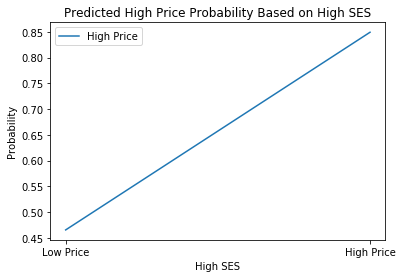

In [14]:
#Predicted Probabilities
df_predict = data.copy()
df_predict['pred_high_price'] = logit_model.predict(x)

#Plot Probabilities by Key Explanatory Variable
df_predict2 = df_predict.groupby(by = 'high_ses').agg(np.mean)[['pred_high_price']]
df_predict2.plot();

#Plot Lables
plt.title('Predicted High Price Probability Based on High SES')
plt.xlabel('High SES'),
plt.ylabel('Probability'),
positions = (0, 1)
labels = ('Low Price', 'High Price')
plt.xticks(positions, labels)
legend = ['High Price']
plt.legend(legend);